# Parallelization in skforecast

## Parallelization rules

The `n_jobs` argument facilitates the parallelization of specific functionalities to enhance speed within the skforecast library. Parallelization has been strategically integrated at two key levels: during the process of forecaster fitting and during the backtesting phase, which also encompasses hyperparameter search. When the `n_jobs` argument is set to its default value of `auto`, the library dynamically determines the number of jobs to employ, guided by the ensuing guidelines:

**Regressor**

If regressor is a `LGBMRegressor`, then `n_jobs = 1` in forecasting fitting and backtesting. This is because `lightgbm` is highly optimized for gradient boosting and parallelizes operations at a very fine-grained level, making additional parallelization unnecessary and potentially harmful due to resource contention.

**Forecaster Fitting**

+ If the forecaster is either `ForecasterDirect` or `ForecasterDirectMultiVariate`, and the underlying regressor happens to be a linear regressor, then `n_jobs` is set to 1.

+ Otherwise, if none of the above conditions hold, the `n_jobs` value is determined as `cpu_count()`, aligning with the number of available CPU cores.

**Backtesting**

- If `refit` is an integer, then `n_jobs = 1`. This is because parallelization doesn`t work with intermittent refit.

- If forecaster is `ForecasterRecursive` and the underlying regressor is linear, `n_jobs` is set to 1.

- If forecaster is `ForecasterRecursive`, the underlying regressor regressor is not a linear regressor and `refit=True`, then `n_jobs` is set to  `cpu_count()`.

- If forecaster is `ForecasterRecursive`, the underlying regressor is not linear and `refit=False`, n_jobs is set to 1.

- If forecaster is `ForecasterDirect` or `ForecasterDirectMultiVariate` and `refit = True`, then `n_jobs` is set to `cpu_count()`.

- If forecaster is `ForecasterDirect` or `ForecasterDirectMultiVariate` and `refit = False`, then `n_jobs` is set to 1.

- If forecaster is `ForecasterRecursiveMultiSeries`, then `n_jobs` is set to `cpu_count()`.

- If forecaster is `ForecasterSarimax` or `ForecasterEquivalentDate`, then `n_jobs = 1`.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

The automatic selection of the parallelization level relies on heuristics and is therefore not guaranteed to be optimal. In addition, it is important to keep in mind that many regressors already parallelize their fitting procedures inherently. As a result, introducing additional parallelization may not necessarily improve overall performance. For a more detailed look at parallelization, visit <a href="https://skforecast.org/latest/api/utils#skforecast.utils.utils.select_n_jobs_backtesting">select_n_jobs_backtesting</a> and <a href="https://skforecast.org/latest/api/utils#skforecast.utils.utils.select_n_jobs_fit_forecaster">select_n_jobs_fit_forecaster</a>.

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import platform
import psutil
import skforecast
import pandas as pd
import numpy as np
import scipy
import sklearn
import time
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.direct import ForecasterDirectMultiVariate

from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import backtesting_forecaster_multiseries

In [2]:
# Versions
# ==============================================================================
print(f"Python version      : {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version  : {skforecast.__version__}")
print(f"pandas version      : {pd.__version__}")
print(f"numpy version       : {np.__version__}")
print(f"scipy version       : {scipy.__version__}")
print("")

# System information
# ==============================================================================
print(f"Processor type: {platform.processor()}")
print(f"Platform type: {platform.platform()}")
print(f"Operating system: {platform.system()}")
print(f"Operating system release: {platform.release()}")
print(f"Operating system version: {platform.version()}")
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version      : 3.12.4
scikit-learn version: 1.5.2
skforecast version  : 0.14.0
pandas version      : 2.2.3
numpy version       : 2.0.2
scipy version       : 1.14.1

Processor type: Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
Platform type: Windows-11-10.0.26100-SP0
Operating system: Windows
Operating system release: 11
Operating system version: 10.0.26100
Number of physical cores: 4
Number of logical cores: 8


## Data

In [3]:
# Data
# ==============================================================================
n = 5_000
rgn = np.random.default_rng(seed=123)
y = pd.Series(rgn.random(size=(n)), name="y")
exog = pd.DataFrame(rgn.random(size=(n, 10)))
exog.columns = [f"exog_{i}" for i in range(exog.shape[1])]
multi_series = pd.DataFrame(rgn.random(size=(n, 10)))
multi_series.columns = [f"series_{i + 1}" for i in range(multi_series.shape[1])]
y_train = y[:-int(n / 2)]
display(y.head())
display(exog.head())   
display(multi_series.head())

0    0.682352
1    0.053821
2    0.220360
3    0.184372
4    0.175906
Name: y, dtype: float64

,exog_0,exog_1,exog_2,exog_3,exog_4,exog_5,exog_6,exog_7,exog_8,exog_9
0,0.593121,0.353471,0.336277,0.399734,0.915459,0.822278,0.480418,0.929802,0.950948,0.863556
1,0.764104,0.638191,0.956624,0.178105,0.434077,0.137480,0.837667,0.768947,0.244235,0.815336
2,0.475312,0.312415,0.353596,0.272162,0.772064,0.110216,0.596551,0.688549,0.651380,0.191837
3,0.039253,0.962713,0.189194,0.910629,0.169796,0.697751,0.830913,0.484824,0.634634,0.862865
4,0.872447,0.861421,0.394829,0.877763,0.286779,0.131008,0.450185,0.898167,0.590147,0.045838


,series_1,series_2,series_3,series_4,series_5,series_6,series_7,series_8,series_9,series_10
0,0.967448,0.580646,0.643348,0.461737,0.450859,0.894496,0.037967,0.097698,0.094356,0.893528
1,0.207450,0.194904,0.377063,0.975065,0.351034,0.812253,0.265956,0.262733,0.784995,0.674256
2,0.520431,0.985069,0.039559,0.541797,0.612761,0.640336,0.823467,0.768387,0.561777,0.600835
3,0.866694,0.165510,0.819767,0.691179,0.717778,0.392694,0.094067,0.271990,0.467866,0.041054
4,0.406310,0.657688,0.630730,0.694424,0.943934,0.888538,0.470363,0.518283,0.719674,0.010789


## Benchmark ForecasterRecursive

-------------------
ForecasterRecursive
-------------------

Ridge(alpha=0.1, random_state=77) {'alpha': [0.1, 0.1, 0.1]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit parallel
Profiling backtesting refit no parallel
Profiling backtesting no refit parallel
Profiling backtesting no refit no parallel
Profiling GridSearch no refit parallel
Profiling GridSearch no refit no parallel

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=1, random_state=77,
              verbose=-1) {'n_estimators': [50, 50], 'max_depth': [5, 5]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit parallel
Profiling backtesting refit no parallel
Profiling backtesting no refit parallel
Profiling backtesting no refit no parallel
Profiling GridSearch no refit parallel
Profiling GridSearch no refit no parallel

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=-1, random_state=77,
              verbose=-1) {'n_estimators': [50, 50], 'max_depth': [5, 5]}

Profiling fit
Prof

,regressor,method,False,True,pct_improvement
0,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,1.877235,1.066511,43.187142
1,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_refit,4.653174,2.635761,43.355620
2,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",create_train_X_y,0.005000,NaN,NaN
3,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",fit,0.077990,NaN,NaN
4,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",gridSearch_no_refit,6.771869,3.884236,42.641598
5,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,1.032562,0.633687,38.629623
6,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_refit,6.890650,2.136856,68.989047
7,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",create_train_X_y,0.005997,NaN,NaN
8,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",fit,0.289961,NaN,NaN
9,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",gridSearch_no_refit,4.545547,1.811150,60.155509


Text(0.5, 0, 'Method')

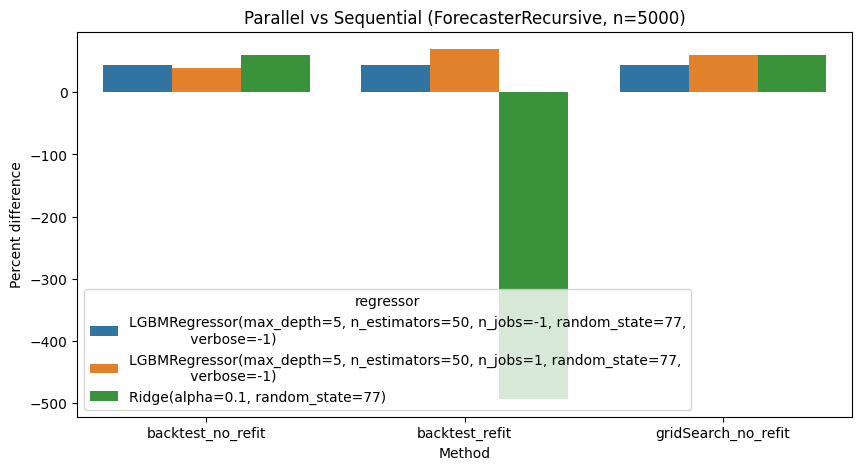

In [4]:
warnings.filterwarnings("ignore")

print("-------------------")
print("ForecasterRecursive")
print("-------------------")
steps = 100
lags = 50
regressors = [
    Ridge(random_state=77, alpha=0.1),
    LGBMRegressor(random_state=77, n_jobs=1, n_estimators=50, max_depth=5, verbose=-1),
    LGBMRegressor(random_state=77, n_jobs=-1, n_estimators=50, max_depth=5, verbose=-1),
]
param_grids = [
    {'alpha': [0.1, 0.1, 0.1]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
]
lags_grid = [50, 50, 50]
elapsed_times = []

for regressor, param_grid in zip(regressors, param_grids):
    print("")
    print(regressor, param_grid)
    print("")
    forecaster = ForecasterRecursive(
                     regressor        = regressor,
                     lags             = lags,
                     transformer_exog = StandardScaler()
                 )
    
    print("Profiling fit")
    start = time.time()
    forecaster.fit(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling create_train_X_y")
    start = time.time()
    _ = forecaster.create_train_X_y(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)

    print("Profiling backtesting refit parallel")
    start = time.time()
    cv = TimeSeriesFold(
            steps              = steps,
            initial_train_size = len(y_train),
            refit              = True,
            fixed_train_size   = False,
          )
    metric, backtest_predictions = backtesting_forecaster(
                                       forecaster    = forecaster,
                                       y             = y,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = -1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting refit no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                       forecaster    = forecaster,
                                       y             = y,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = 1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting no refit parallel")
    start = time.time()
    cv = TimeSeriesFold(
            steps              = steps,
            initial_train_size = len(y_train),
            refit              = False,
          )
    metric, backtest_predictions = backtesting_forecaster(
                                       forecaster    = forecaster,
                                       y             = y,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = -1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting no refit no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                       forecaster    = forecaster,
                                       y             = y,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = 1
                                   )
    end = time.time()
    elapsed_times.append(end - start)    
    
    print("Profiling GridSearch no refit parallel")
    start = time.time()
    cv = TimeSeriesFold(
            steps              = steps,
            initial_train_size = len(y_train),
            refit              = False,
          )
    results_grid = grid_search_forecaster(
                       forecaster    = forecaster,
                       y             = y,
                       exog          = exog,
                       cv            = cv,
                       param_grid    = param_grid,
                       lags_grid     = lags_grid,
                       metric        = 'mean_squared_error',
                       return_best   = False,
                       verbose       = False,
                       show_progress = False,
                       n_jobs        = -1
                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling GridSearch no refit no parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                       forecaster    = forecaster,
                       y             = y,
                       exog          = exog,
                       cv            = cv,
                       param_grid    = param_grid,
                       lags_grid     = lags_grid,
                       metric        = 'mean_squared_error',
                       return_best   = False,
                       verbose       = False,
                       show_progress = False,
                       n_jobs        = 1
                   )
    end = time.time()
    elapsed_times.append(end - start)


methods = [
    "fit",
    "create_train_X_y",
    "backtest_refit_parallel",
    "backtest_refit_noparallel",
    "backtest_no_refit_parallel",
    "backtest_no_refit_noparallel",
    "gridSearch_no_refit_parallel",
    "gridSearch_no_refit_noparallel"
]

results = pd.DataFrame({
    "regressor": np.repeat(np.array([str(regressor) for regressor in regressors]), len(methods)),
    "method": np.tile(methods, len(regressors)),
    "elapsed_time": elapsed_times
})

results['parallel'] = results.method.str.contains("_parallel")
results['method'] = results.method.str.replace("_parallel", "")
results['method'] = results.method.str.replace("_noparallel", "")
results = results.sort_values(by=["regressor", "method", "parallel"])

results_pivot = results.pivot_table(
    index=["regressor", "method"],
    columns="parallel",
    values="elapsed_time"
).reset_index()
results_pivot.columns.name = None
results_pivot["pct_improvement"] = (results_pivot[False] - results_pivot[True]) / results_pivot[False] * 100
display(results_pivot)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_pivot.dropna(), x="method", y="pct_improvement", hue="regressor", ax=ax)
ax.set_title(f"Parallel vs Sequential (ForecasterRecursive, n={n})")
ax.set_ylabel("Percent difference")
ax.set_xlabel("Method")

## Benchmark ForecasterDirect

----------------
ForecasterDirect
----------------

Ridge(alpha=0.1, random_state=77) {'alpha': [0.1, 0.1, 0.1]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit parallel
Profiling backtesting refit no parallel
Profiling backtesting no refit parallel
Profiling backtesting no refit no parallel
Profiling GridSearch no refit parallel
Profiling GridSearch no refit no parallel

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=1, random_state=77,
              verbose=-1) {'n_estimators': [50, 50], 'max_depth': [5, 5]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit parallel
Profiling backtesting refit no parallel
Profiling backtesting no refit parallel
Profiling backtesting no refit no parallel
Profiling GridSearch no refit parallel
Profiling GridSearch no refit no parallel

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=-1, random_state=77,
              verbose=-1) {'n_estimators': [50, 50], 'max_depth': [5, 5]}

Profiling fit
Profiling cre

,regressor,method,False,True,pct_improvement
0,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,2.535272,3.608543,-42.333558
1,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_refit,55.264055,37.172141,32.737217
2,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",create_train_X_y,0.019000,NaN,NaN
3,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",fit,2.221419,NaN,NaN
4,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",gridSearch_no_refit,11.083511,14.643578,-32.120393
5,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,5.157115,6.653340,-29.012849
6,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_refit,93.711537,28.339322,69.758983
7,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",create_train_X_y,0.020111,NaN,NaN
8,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",fit,5.480331,NaN,NaN
9,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",gridSearch_no_refit,19.222537,27.113004,-41.048001


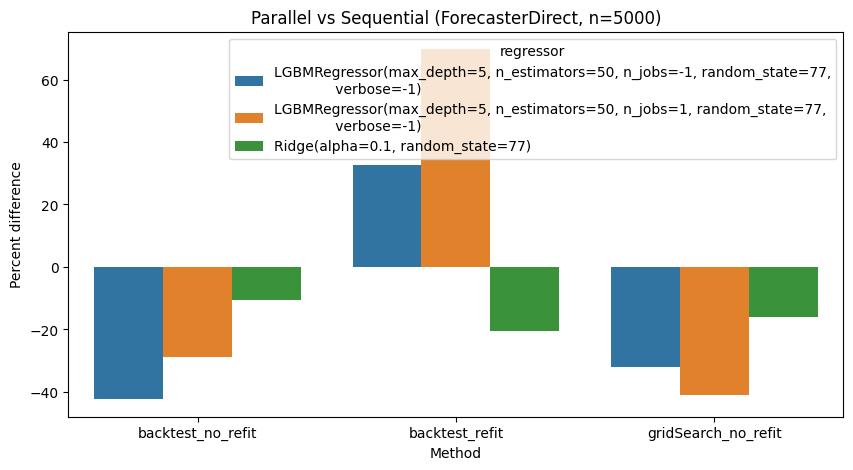

In [6]:
print("----------------")
print("ForecasterDirect")
print("----------------")
steps = 25
lags = 50
regressors = [
    Ridge(random_state=77, alpha=0.1),
    LGBMRegressor(random_state=77, n_jobs=1, n_estimators=50, max_depth=5, verbose=-1),
    LGBMRegressor(random_state=77, n_jobs=-1, n_estimators=50, max_depth=5, verbose=-1),
]
param_grids = [
    {'alpha': [0.1, 0.1, 0.1]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
]
lags_grid = [50, 50, 50]
elapsed_times = []

for regressor, param_grid in zip(regressors, param_grids):
    print("")
    print(regressor, param_grid)
    print("")
    forecaster = ForecasterDirect(
                     regressor        = regressor,
                     lags             = lags,
                     steps            = steps,
                     transformer_exog = StandardScaler()
                 )
    
    print("Profiling fit")
    start = time.time()
    forecaster.fit(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling create_train_X_y")
    start = time.time()
    _ = forecaster.create_train_X_y(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)

    print("Profiling backtesting refit parallel")
    start = time.time()
    cv = TimeSeriesFold(
            steps              = steps,
            initial_train_size = int(len(y) * 0.9),
            refit              = True,
            fixed_train_size   = False,
          )
    metric, backtest_predictions = backtesting_forecaster(
                                       forecaster    = forecaster,
                                       y             = y,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = -1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting refit no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                       forecaster    = forecaster,
                                       y             = y,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = 1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting no refit parallel")
    start = time.time()
    cv = TimeSeriesFold(
            steps              = steps,
            initial_train_size = int(len(y) * 0.9),
            refit              = False,
          )
    metric, backtest_predictions = backtesting_forecaster(
                                       forecaster    = forecaster,
                                       y             = y,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = -1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting no refit no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                       forecaster    = forecaster,
                                       y             = y,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = 1
                                   )
    end = time.time()
    elapsed_times.append(end - start)    
    
    print("Profiling GridSearch no refit parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                       forecaster    = forecaster,
                       y             = y,
                       exog          = exog,
                       cv            = cv,
                       param_grid    = param_grid,
                       lags_grid     = lags_grid,
                       metric        = 'mean_squared_error',
                       return_best   = False,
                       verbose       = False,
                       show_progress = False,
                       n_jobs        = -1
                   )
    end = time.time()
    elapsed_times.append(end - start)
    

    print("Profiling GridSearch no refit no parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                       forecaster    = forecaster,
                       y             = y,
                       exog          = exog,
                       cv            = cv,
                       param_grid    = param_grid,
                       lags_grid     = lags_grid,
                       metric        = 'mean_squared_error',
                       return_best   = False,
                       verbose       = False,
                       show_progress = False,
                       n_jobs        = 1
                   )
    end = time.time()
    elapsed_times.append(end - start)


methods = [
    "fit",
    "create_train_X_y",
    "backtest_refit_parallel",
    "backtest_refit_noparallel",
    "backtest_no_refit_parallel",
    "backtest_no_refit_noparallel",
    "gridSearch_no_refit_parallel",
    "gridSearch_no_refit_noparallel"
]

results = pd.DataFrame({
    "regressor": np.repeat(np.array([str(regressor) for regressor in regressors]), len(methods)),
    "method": np.tile(methods, len(regressors)),
    "elapsed_time": elapsed_times
})

results['parallel'] = results.method.str.contains("_parallel")
results['method'] = results.method.str.replace("_parallel", "")
results['method'] = results.method.str.replace("_noparallel", "")
results = results.sort_values(by=["regressor", "method", "parallel"])

results_pivot = results.pivot_table(
    index=["regressor", "method"],
    columns="parallel",
    values="elapsed_time"
).reset_index()
results_pivot.columns.name = None
results_pivot["pct_improvement"] = (results_pivot[False] - results_pivot[True]) / results_pivot[False] * 100
display(results_pivot)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_pivot.dropna(), x="method", y="pct_improvement", hue="regressor", ax=ax)
ax.set_title(f"Parallel vs Sequential (ForecasterDirect, n={n})")
ax.set_ylabel("Percent difference")
ax.set_xlabel("Method");

## Benchmark ForecasterRecursiveMultiSeries

------------------------------
ForecasterRecursiveMultiSeries
------------------------------

Ridge(alpha=0.1, random_state=77) {'alpha': [0.1, 0.1, 0.1]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit parallel
Profiling backtesting no refit no parallel
Profiling GridSearch no refit parallel
Profiling GridSearch no refit no parallel

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=1, random_state=77,
              verbose=-1) {'n_estimators': [50, 50], 'max_depth': [5, 5]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit parallel
Profiling backtesting no refit no parallel
Profiling GridSearch no refit parallel
Profiling GridSearch no refit no parallel

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=-1, random_state=77,
              verbose=-1) {'n_estimators': [50, 50],

,regressor,method,False,True,pct_improvement
0,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,1.982034,1.161542,41.396462
1,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_refit,10.171752,6.681599,34.312210
2,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",create_train_X_y,0.078507,NaN,NaN
3,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",fit,0.402285,NaN,NaN
4,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",gridSearch_no_refit,7.744162,4.554006,41.194329
5,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_no_refit,2.406072,1.480626,38.462946
6,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",backtest_refit,39.675282,5.294197,86.656182
7,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",create_train_X_y,0.062995,NaN,NaN
8,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",fit,1.294948,NaN,NaN
9,"LGBMRegressor(max_depth=5, n_estimators=50, n_...",gridSearch_no_refit,6.850878,5.208518,23.972982


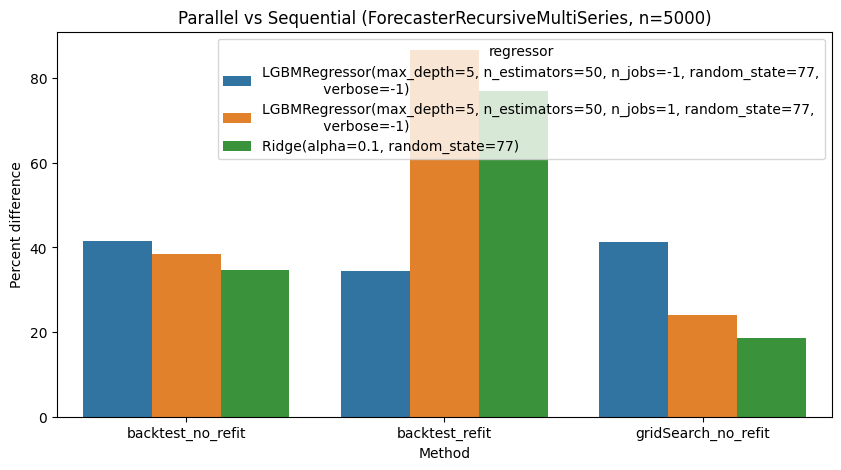

In [11]:
print("------------------------------")
print("ForecasterRecursiveMultiSeries")
print("------------------------------")
steps = 100
lags = 50
regressors = [
    Ridge(random_state=77, alpha=0.1),
    LGBMRegressor(random_state=77, n_jobs=1, n_estimators=50, max_depth=5, verbose=-1),
    LGBMRegressor(random_state=77, n_jobs=-1, n_estimators=50, max_depth=5, verbose=-1),
]
param_grids = [
    {'alpha': [0.1, 0.1, 0.1]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
]
lags_grid = [50, 50, 50]
elapsed_times = []

for regressor, param_grid in zip(regressors, param_grids):
    print("")
    print(regressor, param_grid)
    print("")
    forecaster = ForecasterRecursiveMultiSeries(
                     regressor        = regressor,
                     lags             = lags,
                     transformer_exog = StandardScaler()
                 )
    
    print("Profiling fit")
    start = time.time()
    forecaster.fit(series=multi_series, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling create_train_X_y")
    start = time.time()
    _ = forecaster.create_train_X_y(series=multi_series, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)

    print("Profiling backtesting refit parallel")
    start = time.time()
    cv = TimeSeriesFold(
            initial_train_size = len(y_train),
            refit              = True,
            fixed_train_size   = False,
            steps              = steps,
         )
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                       forecaster    = forecaster,
                                       series        = multi_series,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = -1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                       forecaster    = forecaster,
                                       series        = multi_series,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = 1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting no refit parallel")
    start = time.time()
    cv = TimeSeriesFold(
            initial_train_size = len(y_train),
            refit              = False,
            steps              = steps,
         )
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                       forecaster    = forecaster,
                                       series        = multi_series,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = -1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting no refit no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                       forecaster    = forecaster,
                                       series        = multi_series,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = 1
                                   )
    end = time.time()
    elapsed_times.append(end - start)    
    
    print("Profiling GridSearch no refit parallel")
    start = time.time()
    results_grid = grid_search_forecaster_multiseries(
                       forecaster    = forecaster,
                       series        = multi_series,
                       exog          = exog,
                       cv            = cv,
                       param_grid    = param_grid,
                       lags_grid     = lags_grid,
                       metric        = 'mean_squared_error',
                       return_best   = False,
                       verbose       = False,
                       show_progress = False,
                       n_jobs        = -1
                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling GridSearch no refit no parallel")
    start = time.time()
    cv = TimeSeriesFold(
            initial_train_size = len(y_train),
            refit              = False,
            steps              = steps,
         )
    results_grid = grid_search_forecaster_multiseries(
                       forecaster    = forecaster,
                       series        = multi_series,
                       exog          = exog,
                       cv            = cv,
                       param_grid    = param_grid,
                       lags_grid     = lags_grid,
                       metric        = 'mean_squared_error',
                       return_best   = False,
                       verbose       = False,
                       show_progress = False,
                       n_jobs        = 1
                   )
    end = time.time()
    elapsed_times.append(end - start)


methods = [
    "fit",
    "create_train_X_y",
    "backtest_refit_parallel",
    "backtest_refit_noparallel",
    "backtest_no_refit_parallel",
    "backtest_no_refit_noparallel",
    "gridSearch_no_refit_parallel",
    "gridSearch_no_refit_noparallel"
]

results = pd.DataFrame({
    "regressor": np.repeat(np.array([str(regressor) for regressor in regressors]), len(methods)),
    "method": np.tile(methods, len(regressors)),
    "elapsed_time": elapsed_times
})

results['parallel'] = results.method.str.contains("_parallel")
results['method'] = results.method.str.replace("_parallel", "")
results['method'] = results.method.str.replace("_noparallel", "")
results = results.sort_values(by=["regressor", "method", "parallel"])

results_pivot = results.pivot_table(
    index=["regressor", "method"],
    columns="parallel",
    values="elapsed_time"
).reset_index()
results_pivot.columns.name = None
results_pivot["pct_improvement"] = (results_pivot[False] - results_pivot[True]) / results_pivot[False] * 100
display(results_pivot)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_pivot.dropna(), x="method", y="pct_improvement", hue="regressor", ax=ax)
ax.set_title(f"Parallel vs Sequential (ForecasterRecursiveMultiSeries, n={n})")
ax.set_ylabel("Percent difference")
ax.set_xlabel("Method");

## Benchmark ForecasterDirectMultiVariate

In [12]:
print("----------------------------")
print("ForecasterDirectMultiVariate")
print("----------------------------")
steps = 25
lags = 50
regressors = [
    Ridge(random_state=77, alpha=0.1),
    LGBMRegressor(random_state=77, n_jobs=1, n_estimators=50, max_depth=5, verbose=-1),
    LGBMRegressor(random_state=77, n_jobs=-1, n_estimators=50, max_depth=5, verbose=-1),
]
param_grids = [
    {'alpha': [0.1, 0.1, 0.1]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
    {'n_estimators': [50, 50], 'max_depth': [5, 5]},
]
lags_grid = [50, 50, 50]
elapsed_times = []

for regressor, param_grid in zip(regressors, param_grids):
    print("")
    print(regressor, param_grid)
    print("")
    forecaster = ForecasterDirectMultiVariate(
                     regressor        = regressor,
                     lags             = lags,
                     steps            = steps,
                     level            = "series_1",
                     transformer_exog = StandardScaler()
                 )
    
    print("Profiling fit")
    start = time.time()
    forecaster.fit(series=multi_series, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling create_train_X_y")
    start = time.time()
    _ = forecaster.create_train_X_y(series=multi_series, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)

    print("Profiling backtesting refit parallel")
    start = time.time()
    cv = TimeSeriesFold(
            steps              = steps,
            initial_train_size = int(len(y) * 0.9),
            refit              = True,
            fixed_train_size   = False,
        )
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                       forecaster    = forecaster,
                                       series        = multi_series,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = -1
                                   )
    end = time.time()
    elapsed_times.append(end - start)

    print("Profiling backtesting refit no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                       forecaster          = forecaster,
                                       series              = multi_series,
                                       exog                = exog,
                                        cv                  = cv,
                                       metric              = 'mean_squared_error',
                                       interval            = None,
                                       n_boot              = 500,
                                       random_state        = 123,
                                       verbose             = False,
                                       show_progress       = False,
                                       n_jobs              = 1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting no refit parallel")
    start = time.time()
    cv = TimeSeriesFold(
            steps              = steps,
            initial_train_size = int(len(y) * 0.9),
            refit              = False,
        )
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                       forecaster          = forecaster,
                                       series              = multi_series,
                                       exog                = exog,
                                       cv                  = cv,
                                       metric              = 'mean_squared_error',
                                       interval            = None,
                                       n_boot              = 500,
                                       random_state        = 123,
                                       verbose             = False,
                                       show_progress       = False,
                                       n_jobs              = -1
                                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling backtesting no refit no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster_multiseries(
                                       forecaster    = forecaster,
                                       series        = multi_series,
                                       exog          = exog,
                                       cv            = cv,
                                       metric        = 'mean_squared_error',
                                       interval      = None,
                                       n_boot        = 500,
                                       random_state  = 123,
                                       verbose       = False,
                                       show_progress = False,
                                       n_jobs        = 1
                                   )
    end = time.time()
    elapsed_times.append(end - start)    
    
    print("Profiling GridSearch no refit parallel")
    start = time.time()
    results_grid = grid_search_forecaster_multiseries(
                       forecaster    = forecaster,
                       series        = multi_series,
                       exog          = exog,
                       cv            = cv,
                       param_grid    = param_grid,
                       lags_grid     = lags_grid,
                       metric        = 'mean_squared_error',
                       return_best   = False,
                       verbose       = False,
                       show_progress = False,
                       n_jobs        = -1
                   )
    end = time.time()
    elapsed_times.append(end - start)
    
    print("Profiling GridSearch no refit no parallel")
    start = time.time()
    results_grid = grid_search_forecaster_multiseries(
                       forecaster    = forecaster,
                       series        = multi_series,
                       exog          = exog,
                       cv            = cv,
                       param_grid    = param_grid,
                       lags_grid     = lags_grid,
                       metric        = 'mean_squared_error',
                       return_best   = False,
                       verbose       = False,
                       show_progress = False,
                       n_jobs        = 1
                   )
    end = time.time()
    elapsed_times.append(end - start)

methods = [
    "fit",
    "create_train_X_y",
    "backtest_refit_parallel",
    "backtest_refit_noparallel",
    "backtest_no_refit_parallel",
    "backtest_no_refit_noparallel",
    "gridSearch_no_refit_parallel",
    "gridSearch_no_refit_noparallel"
]

results = pd.DataFrame({
    "regressor": np.repeat(np.array([str(regressor) for regressor in regressors]), len(methods)),
    "method": np.tile(methods, len(regressors)),
    "elapsed_time": elapsed_times
})

results['parallel'] = results.method.str.contains("_parallel")
results['method'] = results.method.str.replace("_parallel", "")
results['method'] = results.method.str.replace("_noparallel", "")
results = results.sort_values(by=["regressor", "method", "parallel"])

results_pivot = results.pivot_table(index=["regressor", "method"], columns="parallel", values="elapsed_time").reset_index()
results_pivot.columns.name = None
results_pivot["pct_improvement"] = (results_pivot[False] - results_pivot[True]) / results_pivot[False] * 100
display(results_pivot)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_pivot.dropna(), x="method", y="pct_improvement", hue="regressor", ax=ax)
ax.set_title(f"Parallel vs Sequential (ForecasterDirectMultiVariate, n={n})")
ax.set_ylabel("Percent difference")
ax.set_xlabel("Method");

----------------------------
ForecasterDirectMultiVariate
----------------------------

Ridge(alpha=0.1, random_state=77) {'alpha': [0.1, 0.1, 0.1]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit parallel
Profiling backtesting refit no parallel
Profiling backtesting no refit parallel
Profiling backtesting no refit no parallel
Profiling GridSearch no refit parallel
Profiling GridSearch no refit no parallel

LGBMRegressor(max_depth=5, n_estimators=50, n_jobs=1, random_state=77,
              verbose=-1) {'n_estimators': [50, 50], 'max_depth': [5, 5]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit parallel
Profiling backtesting refit no parallel
Profiling backtesting no refit parallel
Profiling backtesting no refit no parallel


KeyboardInterrupt: 